<a href="https://colab.research.google.com/github/vybhav-acharya/NLP_stuff/blob/main/Copy_of_ANN_NLP_Word2Vec_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [331]:
pip install tensorflow_text

In [332]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [333]:
df = pd.read_csv('/content/sample_data/Restaurant_Reviews_-_Restaurant_Reviews.csv')

# New Section

In [334]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [335]:
df.shape

(1000, 2)

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


1    500
0    500
Name: Liked, dtype: int64

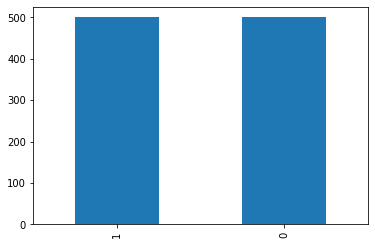

In [337]:
import matplotlib.pyplot as plt
df['Liked'].value_counts().plot(kind ='bar') 
df['Liked'].value_counts()

'Also there are combos like a burger, fries, and beer for 23 which is a decent deal.'

In [339]:

df['Review'].isnull().sum()
df.drop_duplicates(subset=['Liked','Review'],keep='first',inplace=True) 
print(df.shape)

(996, 2)


In [340]:
x=df['Review'].values#inputs
y=df['Liked'].values #outputs

In [341]:
import re
import nltk
import numpy as np
nltk.download('stopwords') #stopwords download
nltk.download('punkt') #tokenizer download  
nltk.download('wordnet') #lemmatizer download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [342]:
# function to clean and pre-process the text.

def clean_reviews(review):  
    
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

In [343]:
df['clean_review']=df['Review'].apply(clean_reviews)

(996,)

In [345]:
from keras.preprocessing.text import one_hot,Tokenizer
tok = Tokenizer()
tok.fit_on_texts(df['clean_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['clean_review'])


In [346]:
max_rev_len=100  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [347]:
# now padding to have a amximum length of 1565
from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 1565 words.
pad_rev.shape
pad_rev[0].shape

(100,)

In [348]:
import gensim
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[]
sum=0
for review in df['Review']:
  sents=tokenizer.tokenize(review.strip())
  sum+=len(sents)
  for sent in sents:
    cleaned_sent=clean_reviews(sent)
    sentences.append(cleaned_sent.split()) 
w2v_model=gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)

In [349]:
word_vec_dict={}
vocab=w2v_model.wv.vocab

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i]=embed_vector

In [350]:
 x_train,x_test,y_train,y_test = train_test_split(pad_rev,y,random_state=0)

In [351]:
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(Flatten())
model.add(Dense(36,activation='LeakyReLU'))
model.add(Dropout(0.50))
model.add(Dense(18,activation='LeakyReLU'))
model.add(Dropout(0.50))
model.add(Dense(1,activation='sigmoid'))

In [352]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [353]:
epochs=10
batch_size=64
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 300)          530700    
                                                                 
 flatten_9 (Flatten)         (None, 30000)             0         
                                                                 
 dense_27 (Dense)            (None, 36)                1080036   
                                                                 
 dropout_18 (Dropout)        (None, 36)                0         
                                                                 
 dense_28 (Dense)            (None, 18)                666       
                                                                 
 dropout_19 (Dropout)        (None, 18)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                

In [354]:
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


Epoch 1/10
12/12 [==============================] - 1s 10ms/step - loss: 0.6952 - accuracy: 0.4766
Epoch 2/10
12/12 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.5435
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.6426 - accuracy: 0.6801
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4858 - accuracy: 0.8527
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.2791 - accuracy: 0.9304
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 0.1333 - accuracy: 0.9665
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0748 - accuracy: 0.9866
Epoch 8/10
12/12 [==============================] - 0s 10ms/step - loss: 0.0460 - accuracy: 0.9933
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0271 - accuracy: 0.9946
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9973


In [355]:
loss,accuracy=model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.9490 - accuracy: 0.7068


In [356]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 5ms/step - loss: 0.9490 - accuracy: 0.7068


[0.9490344524383545, 0.7068272829055786]